In [1]:
import pandas as pd
import numpy as np
import PyPDF4
import fitz
from sklearn import tree
from sklearn import metrics
from sklearn import ensemble
from sklearn import model_selection
from PIL import Image
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [20]:
df = pd.read_csv("./input/siim/train-rle.csv")
df.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6904.151787520...,-1
1,1.2.276.0.7230010.3.1.4.8323329.13666.15178752...,557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...
2,1.2.276.0.7230010.3.1.4.8323329.11028.15178752...,-1
3,1.2.276.0.7230010.3.1.4.8323329.10366.15178752...,514175 10 1008 29 994 30 993 32 991 33 990 34 ...
4,1.2.276.0.7230010.3.1.4.8323329.10016.15178752...,592184 33 976 58 956 73 941 88 926 102 917 109...


In [21]:
def create_dataset(training_df, image_dir):
    """
    This function takes the training dataframe
    and outputs training array and labels
    :param training_df: dataframe with ImageId, Target columns
    :param image_dir: location of images (folder), string
    :return: X, y (training array with features and labels)
    """
    # create empty list to store image vectors
    images = []

    # create empty list to store targets
    targets = []

    # loop over the dataframe
    for index, row in tqdm(
        training_df.iterrows(),
        total=len(training_df),
        desc="processing images"
    ):

        # get image id
        image_id = row["ImageId"]

        # create image path
        image_path = os.path.join(image_dir, image_id)

        # open image using PIL
        image = Image.open(image_path + ".png")

        # resize image to 256x256. we use bilinear resampling
        image = image.resize((256, 256), resample=Image.BILINEAR)

        # convert image to array
        image = np.array(image)

        # ravel
        image = image.ravel()

        # append images and targets lists
        images.append(image)
        targets.append(int(row["target"]))

    # convert list of list of images to numpy array
    images = np.array(images)

    # print size of this array
    print(images.shape)
    return images, targets


if __name__ == "__main__":
    csv_path = "./input/siim/train-rle.csv"
    image_path = "./input/siim/dicom-images-train/*/*/*.dcm"

    df = pd.read_csv(csv_path)

    # we create a new column called kfold and fill it with -1
    df["kfold"] = -1

    # the next step is to randomize the rows of the data
    df = df.sample(frac=1).reset_index(drop=True)

    # fetch labels
    y = df.EncodedPixels.values

    # initiate the kfold class from model_selection module
    kf = model_selection.StratifiedKFold(n_splits=5)

    # fill the new kfold column
    for f, (t_, v_) in enumerate(kf.split(X=df, y=y)):
        df.loc[v_, 'kfold'] = f

    # we go over the folds created
    for fold_ in range(5):

        # temporary dataframes for train and test
        train_df = df[df.kfold != fold_].reset_index(drop=True)
        test_df = df[df.kfold == fold_].reset_index(drop=True)
        # create train dataset
        # you can move this outside to save some computation time

        xtrain, ytrain = create_dataset(train_df, image_path)
        # create test dataset
        # you can move this outside to save some computation time
        xtest, ytest = create_dataset(test_df, image_path)

        # fit random forest without any modification of params
        clf = ensemble.RandomForestClassifier(n_jobs=-1)
        clf.fit(xtrain, ytrain)

        # predict probability of class 1
        preds = clf.predict_proba(xtest)[:, 1]

        # print results
        print(f"FOLD: {fold_}")
        print(f"AUC = {metrics.roc_auc_score(ytest, preds)}")
        print("")

AttributeError: 'DataFrame' object has no attribute 'EncodedPixels'

In [3]:
# this is our global size of label text
# on the plots
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)

In [4]:
# This line ensures that the plot is displayed
# inside the notebook
%matplotlib inline

In [5]:
df = pd.read_csv("./input/winequality-red.csv")

In [6]:
# a mapping dictionary that maps the quality values from 0 to 5
quality_mapping = {
3: 0,
4: 1,
5: 2,
6: 3,
7: 4,
8: 5
}
# you can use the map function of pandas with
# any dictionary to convert the values in a given
# column to values in the dictionary
df.loc[:, "quality"] = df.quality.map(quality_mapping)

In [7]:
# use sample with frac=1 to shuffle the dataframe
# we reset the indices since they change after
# shuffling the dataframe
df = df.sample(frac=1).reset_index(drop=True)
# top 1000 rows are selected
# for training
df_train = df.head(1000)
# bottom 599 values are selected
# for testing/validation
df_test = df.tail(599)

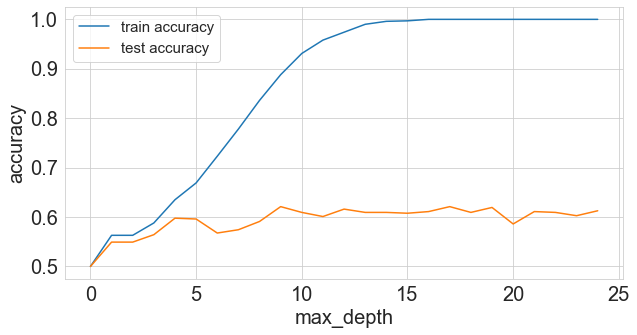

In [8]:
# initialize lists to store accuracies
# for training and test data
# we start with 50% accuracy
train_accuracies = [0.5]
test_accuracies = [0.5]
# iterate over a few depth values
for depth in range(1, 25):
    # init the model
    clf = tree.DecisionTreeClassifier(max_depth=depth)
    # columns/features for training
    # note that, this can be done outside
    # the loop
    cols = ['fixed acidity',
            'volatile acidity',
            'citric acid',
            'residual sugar',
            'chlorides',
            'free sulfur dioxide',
            'total sulfur dioxide',
            'density',
            'pH',
            'sulphates',
            'alcohol'
            ]
    # fit the model on given features
    clf.fit(df_train[cols], df_train.quality)
    # create training & test predictions
    train_predictions = clf.predict(df_train[cols])
    test_predictions = clf.predict(df_test[cols])
    # calculate training & test accuracies
    train_accuracy = metrics.accuracy_score(
    df_train.quality, train_predictions
    )
    test_accuracy = metrics.accuracy_score(
    df_test.quality, test_predictions
    )
    # append accuracies
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# create two plots using matplotlib
# and seaborn
plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")
plt.plot(train_accuracies, label="train accuracy")
plt.plot(test_accuracies, label="test accuracy")
plt.legend(loc="upper left", prop={'size': 15})
plt.xticks(range(0, 26, 5))
plt.xlabel("max_depth", size=20)
plt.ylabel("accuracy", size=20)
plt.show()

Text(0, 0.5, 'count')

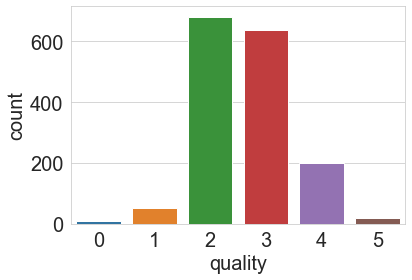

In [9]:
b = sns.countplot(x='quality', data=df)
b.set_xlabel("quality", fontsize=20)
b.set_ylabel("count", fontsize=20)

In [10]:
df_m = pd.read_csv("./input/mnist_train.csv")

In [11]:
df_f = pd.read_csv("./input/mnist_train_folds.csv")

In [13]:
df_f.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28,kfold
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Text(0, 0.5, 'count')

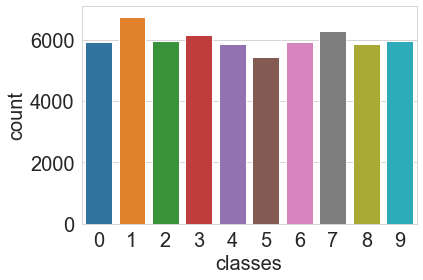

In [12]:
c = sns.countplot(x='label', data=df_m)
c.set_xlabel("classes", fontsize=20)
c.set_ylabel("count", fontsize=20)

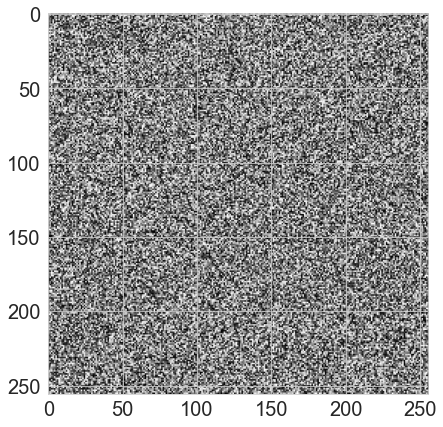

In [14]:
# generate random numpy array with values from 0 to 255
# and a size of 256x256
random_image = np.random.randint(0, 256, (256, 256))
# initialize plot
plt.figure(figsize=(7, 7))
# show grayscale image, nb: cmap, vmin and vmax
plt.imshow(random_image, cmap='gray', vmin=0, vmax=255)
plt.show()